# CS-109: Fall 2015  -- Lab 7

## Decision Trees, Random Forests, Ensemble Methods

***
This is a very quick run-through of some basic nonparametric (the old kind) prediction methods

* Decision Trees
* Random Forests
* Ensemble Methods

For more reading, check out An Introduction to Statistical Learning by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani (available through [Springer](http://www-bcf.usc.edu/~gareth/ISL/), as well as the scikit-learn [documentation](http://scikit-learn.org/stable/modules/tree.html).

***

In [0]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# special matplotlib argument for improved plots
from matplotlib import rcParams


In [0]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Generic classification and optimization functions from last lab
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# clf - original classifier
# parameters - grid to search over
# X - usually your training X matrix
# y - usually your training y 
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.cv_results_
    best = gs.best_estimator_
    return best

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Important parameters
# indf - Input dataframe
# featurenames - vector of names of predictors
# targetname - name of column you want to predict (e.g. 0 or 1, 'M' or 'F', 
#              'yes' or 'no')
# target1val - particular value you want to have as a 1 in the target
# mask - boolean vector indicating test set (~mask is training set)
# reuse_split - dictionary that contains traning and testing dataframes 
#              (we'll use this to test different classifiers on the same 
#              test-train splits)
# score_func - we've used the accuracy as a way of scoring algorithms but 
#              this can be more general later on
# n_folds - Number of folds for cross validation ()
# n_jobs - used for parallelization
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask.all() !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Plot tree containing only two covariates
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

from matplotlib.colors import ListedColormap
# cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_2tree(ax, Xtr, Xte, ytr, yte, clf, plot_train = True, plot_test = True, lab = ['Feature 1', 'Feature 2'], mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.3, psize=10, zfunc=False):
    # Create a meshgrid as our test data
    plt.figure(figsize=(15,10))
    plot_step= 0.05
    xmin, xmax= Xtr[:,0].min(), Xtr[:,0].max()
    ymin, ymax= Xtr[:,1].min(), Xtr[:,1].max()
    xx, yy = np.meshgrid(np.arange(xmin, xmax, plot_step), np.arange(ymin, ymax, plot_step) )

    # Re-cast every coordinate in the meshgrid as a 2D point
    Xplot= np.c_[xx.ravel(), yy.ravel()]


    # Predict the class
    Z = clfTree1.predict( Xplot )

    # Re-shape the results
    Z= Z.reshape( xx.shape )
    cs = plt.contourf(xx, yy, Z, cmap= cmap_light, alpha=0.3)
  
    # Overlay training samples
    if (plot_train == True):
        plt.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, alpha=alpha,edgecolor="k") 
    # and testing points
    if (plot_test == True):
        plt.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s")

    plt.xlabel(lab[0])
    plt.ylabel(lab[1])
    plt.title("Boundary for decision tree classifier",fontsize=7.5)


***

<img src="http://www.winemaniacs.com/wp-content/uploads/2013/04/WineRotator-2000x925.jpg">

Can a wine maker predict how a wine will be received based on the chemical properties of the wine? Are there chemical indicators that correlate more strongly with the perceived "quality" of a wine?

In this lab we'll examine the wine quality dataset hosted on the <a href="https://archive.ics.uci.edu/ml/datasets/Wine+Quality">UCI website</a>. This data records 11 chemical properties (such as the concentrations of sugar, citric acid, alcohol, pH etc.) of thousands of red and white wines from northern Portugal, as well as the quality of the wines, recorded on a scale from 1 to 10. In this problem, we will only look at the data for *red* wine.

## Let's grab some Data

Import only the data for **red** wine from the <a href='https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/'>dataset repository</a>. **Build a pandas dataframe** from the csv file and **print the head**. You might have to change the default delimiter used by the <a href='http://pandas.pydata.org/pandas-docs/stable/generated/pandas.io.parsers.read_csv.html'>read_csv</a> function in Pandas.

In [3]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


(1599, 12)


(array([ 10.,   0.,  53.,   0., 681.,   0., 638.,   0., 199.,  18.]),
 array([3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. ]),
 <a list of 10 Patch objects>)

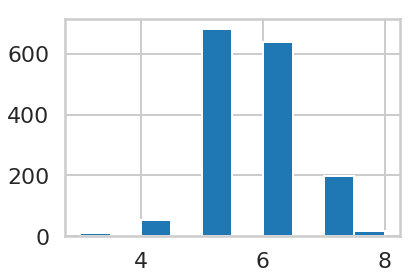

In [4]:
print df.shape

plt.hist(df.quality)

We will use the *quality* column as our target variable. Except that we will simplify the problem to a binary world in which wines are either "bad" ($\text{score} < 7$) or "good" ($\text{score} \geq 7)$. For example, if originally $Y = [1,3,8,4,7]$, the new $Y$ should be $[0,0,1,0,1]$.

In [5]:
Y = df['quality'].values
df_tmp = df.drop('quality',1)
Y = np.array([1 if y>=7 else 0 for y in Y])
X = df_tmp.as_matrix()

df['target'] = (df['quality'].values >=7)*1

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Let's get the column names corresponding to the predictors

In [0]:
Xnames = list(df.columns.values[1:11])

### Recall: Evaluation Metrics
First, notice that we're actually dealing with a relatively small number of good wines in out dataset.

In [7]:
np.mean(df['target'])

0.1357098186366479

In the last lab we went over some metrics that 
Usually, the goal is to identify the members of the positive class (the rare class) successfully -- this could be either the good wines or the patients presenting a rare disease. It is common practice to define the following ratios:

The **recall** rate (also called the sensitivity or the true positive rate) is the ratio of true positive guesses among all positives:
$$\text{recall} = \frac{TP}{P}=\frac{TP}{TP+FN}.$$
The **precision** is the ratio of the true positive guesses over all the positive guesses:
$$\text{precision} = \frac{TP}{TP+FP}.$$
Because precision and recall both provide valuable information about the quality of a classifier, we often want to combine them into a single general-purpose score. The **F1** score is defined as the harmonic mean of recall and precision:
$$F_1 = \frac{2\times\text{recall}\times\text{precision}}{\text{recall} + \text{precision}}.$$

The harmonic mean of two numbers is closer to the smaller of the two numbers than the standard arithmetic mean. The F1 score thus tends to favor classifiers that are strong in both precision and recall, rather than classifiers that emphasize one at the cost of the other.

***We'll use the `score_func` option set to ``f1`` in our `do_classify` function for these classifications.** See, it is super general! There are a lot of evaluation metrics we can use, see the [documentation](http://scikit-learn.org/stable/modules/model_evaluation.html).

# 1. Decision Trees (Classification)

Decision trees are very intuitive classification tools, consider the following tree:
<img src="https://upload.wikimedia.org/wikipedia/commons/f/f3/CART_tree_titanic_survivors.png">


This tree predicts the **survival of passengers** on the titanic. The use is very simple, say someone gives you this tree and a new person. In order to predict whether or not the person would have died on the titanic, you ask the following questions, in order:

1. **Is the person male?** If no, we predict they would have survived. If yes, continue.
2. **Is the person older than 9.5 years?**  If yes, we predict they would have died. If no, continue.
3. **Did the person have more than 3 or more siblings?** If yes, we predict they would have died. If no, they would have survived

The question we'll move to now is how would one build such a tree? Is it useful for doing anything other than explaining the tragic end of the movie **Titanic**? 

#### It could have been less tragic, fairly easily

<img src="https://github.com/cs109/2015lab7/blob/master/images/jack.jpg?raw=1">

## Fitting Decision Trees

Building a decision tree isn't really much harder than reading one, here's the essential rundown:

Let's say we're building a classification tree by considering a list of predictors. In our example above we want to be able to classify good wines from the rest using things like fixed acidity, pH, alcohol, etc. These are all continuous variables, generically let's call them $X_{i1}, X_{i2}, ..., X_{ip}$ ($i$ for wine, $p$ for predictors). We also have an observed label $Y_i$ for each wine. 

We first assign everyone to the same class, say $\hat{Y}_i = 1$. We can calculate the squared error $Err = \sum_i {(\hat{Y}_i - Y_i)^2}$

- At **each step** of the algorithm we consider a list of possible decision (or split), for example $X_{10} > 12$, i.e. alcohol content is greater than 12%.
- For each possible decision we recalculate the predictor for that rule, for example $\hat{Y}_i = 1$ if $X_{10} > 12$ and $0$ otherwise.
- We recalculate the error for each possible decision: $Err = \sum_i {(\hat{Y}_i - Y_i)^2}$
- We choose the decision that reduces the error by the largest amount
- then keep going...

<img src="https://github.com/cs109/2015lab7/blob/master/images/Decision_tree.png?raw=1">


In this lab we'll consider classification but Decision trees can be use for regression (prediction of continuous outcomes) as well.

In [8]:
# Create test/train mask
itrain, itest = train_test_split(xrange(df.shape[0]), train_size=0.6)
mask=np.ones(df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [9]:
# make sure we didn't get unlucky in our mask selection
print "% Good wines in Training:", np.mean(df.target[mask])
print "% Good wines in Testing:", np.mean(df.target[~mask])

% Good wines in Training: 0.132429614181439
% Good wines in Testing: 0.140625


### Fit a Decision Tree

Let's first fit on two covariates to help us visualize what's going on. Have a look at the options on the [help page](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). We'll be optimizing over two options here: `max_depth` - the maximum depth of the tree, `min_samples_leaf` - the minimum number of samples required to be at a leaf node.

In [10]:
from sklearn import tree
clfTree1 = tree.DecisionTreeClassifier()

parameters = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]}
clfTree1, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree1, parameters, df, 
                                                     ['alcohol', 'fixed acidity'],'target', 1, 
                                                     mask=mask, n_jobs = 4, score_func = 'f1')

using mask
BEST {'max_depth': 3, 'min_samples_leaf': 5} 0.35184633464091236 {'std_train_score': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.16938808, 0.16938808, 0.16938808, 0.16938808,
       0.16938808, 0.16938808, 0.03244894, 0.03469312, 0.0327913 ,
       0.0327913 , 0.03738217, 0.0330078 , 0.04739604, 0.04870634,
       0.0390976 , 0.04011548, 0.047221  , 0.05205204, 0.01590805,
       0.02295788, 0.03171062, 0.02315591, 0.03457062, 0.03784761,
       0.03336462, 0.03901627, 0.04807624, 0.0397541 , 0.04284938,
       0.04980047, 0.02593135, 0.02636888, 0.04957831, 0.04190287,
       0.03756164, 0.03854764]), 'split4_test_score': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.21428571, 0.21428571, 0.21428571, 0.21428571,
       0.21428571, 0.21428571, 0.21428571, 0.21428571, 0.21428571,
       0.21428571, 0.21428571, 0.21428571, 0.21428571, 0.21428571,
       0.21428571, 0.21428571, 0.21428571, 0.2

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


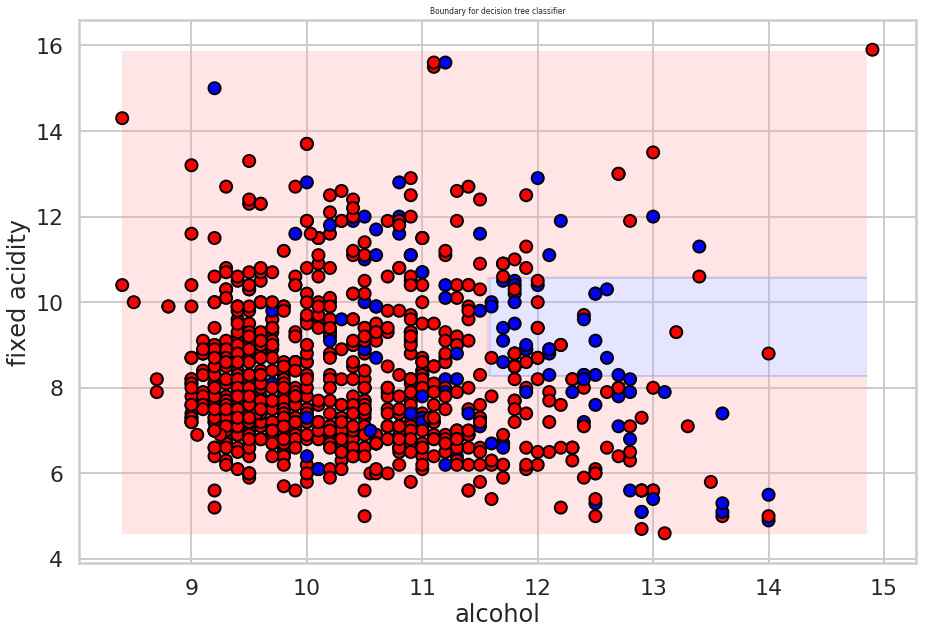

In [11]:
plot_2tree(plt, Xtrain, Xtest, ytrain, ytest, clfTree1, 
           lab = ['alcohol', 'fixed acidity'], alpha = 1, plot_test = False)

### Let's plot the actual test data as well (in squares)

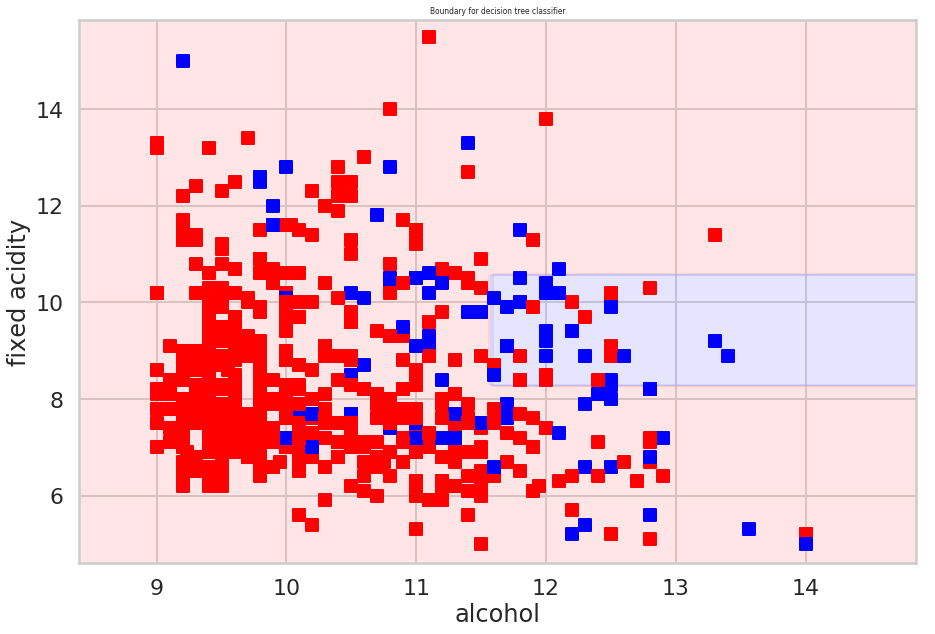

In [12]:
plot_2tree(plt, Xtrain, Xtest, ytrain, ytest, clfTree1, 
           lab = ['alcohol', 'fixed acidity'], alpha = 1, plot_train = False)

## Let's play around with this to see the possibly decision boundaries

using mask
BEST {'max_depth': None, 'min_samples_leaf': 4} 0.2564554550998764 {'std_train_score': array([0.04316904, 0.04337207, 0.03903224]), 'split4_test_score': array([0.07142857, 0.        , 0.14814815]), 'param_max_depth': masked_array(data=[None, None, None],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'rank_test_score': array([1, 2, 3], dtype=int32), 'split2_train_score': array([0.54658385, 0.50980392, 0.50649351]), 'std_score_time': array([5.23842894e-05, 1.29811733e-04, 1.07278823e-05]), 'split4_train_score': array([0.6       , 0.60335196, 0.5308642 ]), 'split2_test_score': array([0.48888889, 0.46511628, 0.31578947]), 'param_min_samples_leaf': masked_array(data=[4, 5, 6],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'mean_fit_time': array([0.0021554 , 0.00097604, 0.00077419]), 'split3_train_score': array([0.67403315, 0.63687151, 0.60571429]), 'split0_train_score': array([0.60714286, 0.

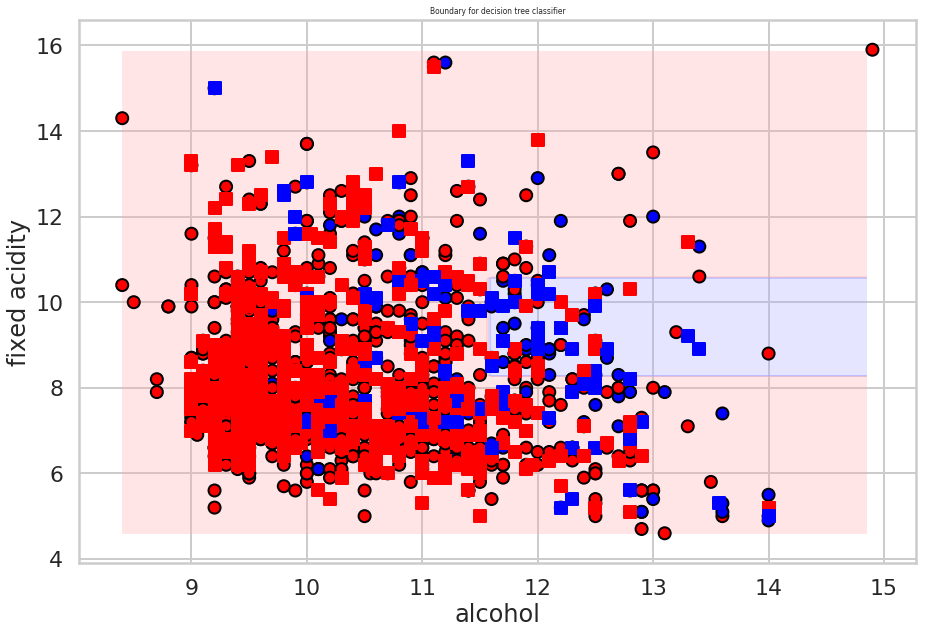

In [13]:
from sklearn import tree
clfTree_temp = tree.DecisionTreeClassifier()

parameters = {"max_depth": [None], 'min_samples_leaf': [4, 5, 6]}
clfTree_temp, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree_temp, parameters, df, 
                                                     ['alcohol', 'fixed acidity'],'target', 1, 
                                                     mask=mask, n_jobs = 4, score_func = 'f1')
plot_2tree(plt, Xtrain, Xtest, ytrain, ytest, clfTree_temp, 
           lab = ['alcohol', 'fixed acidity'], alpha = 1, plot_train = True)

## More Predictors

The prediction accuracy says we're doing quite well, but it seems like that's being driven by having such a large number of not excellent wines, even when optimizing the $F1$ score. Let's see if we can't increase the including all the covariates.

In [14]:
clfTree2 = tree.DecisionTreeClassifier()

parameters = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
clfTree2, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree2, parameters, df, 
                                                     Xnames,'target', 1, 
                                                     mask=mask, n_jobs = 4, score_func = 'f1')

using mask
BEST {'max_depth': 5, 'min_samples_leaf': 1} 0.4872263865773174 {'std_train_score': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01786901, 0.01786901, 0.01786901, 0.01786901, 0.01786901,
       0.01786901, 0.01786901, 0.01786901, 0.01786901, 0.01786901,
       0.05715703, 0.05779571, 0.05779571, 0.05219872, 0.05219872,
       0.05219872, 0.05219872, 0.05219872, 0.05500513, 0.05500513,
       0.04140727, 0.03937931, 0.04253831, 0.04796221, 0.04340261,
       0.05522337, 0.05899842, 0.05755954, 0.05492579, 0.06167819,
       0.01677471, 0.01868767, 0.03298063, 0.0277673 , 0.02335607,
       0.04983097, 0.0412632 , 0.03218814, 0.03523581, 0.04233661,
       0.01159745, 0.02193117, 0.02311875, 0.02857254, 0.02566688,
       0.03846864, 0.05388742, 0.02173502, 0.02940631, 0.0389202 ,
       0.02361752, 0.01750156, 0.01521041, 0.01696885, 0.02233149,
       0.0297531 , 0.03808663, 0.0

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# 2. Random Forests

Recall from class that the random forest technique works by aggregating the results from a number of randomly perturbed decision trees constructed to explain the data.

### A bit on bootstrap aggregation
The idea of random forests arises naturally by first considering Tree bagging. In tree bagging we do the following $b$ times:

1. Take a random subsample of your data
2. Build a classification (or regression) tree like in the previous section
3. repeat

For a new data point we can then simply run that point through all the $b$ trees constructed, get all the decisions $\hat{Y}_1,..., \hat{Y}_b$ and take a majority vote. This form of averaging gets rid of some of the over-fitting issues found in just using one tree. Plus fitting these trees costs a lot computationally, so what else can we do?

### Leads to Random Forests?
This method is very similar to the bootstrap aggregation method. However, as the name suggests some extra randomness is injected into the building of the trees. It turns out that the trees that are build from the random subsample of your data are quite similar, so the solution is quite simple. In Random Forests we do the following $b$ times:

1. Take a random subsample of your data
2. Select m variables at random out of all M possible variables (independently for each node).
3. Find the best split on the selected m variables. Build out the entire tree.
4. repeat

We take a majority vote the same as before. Have a look at the help page for the [Random Forest Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), we'll be optimizing two options: `n_estimators` - the number of trees in the forest, `max_features` - the number of features to consider when looking for the best split (step 2 above).


In [15]:
from sklearn.ensemble import RandomForestClassifier

clfForest = RandomForestClassifier()

parameters = {"n_estimators": range(1, 20)}
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, 
                                                       df, Xnames, 'target', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')


using mask
BEST {'n_estimators': 11} 0.44621167966351577 {'rank_test_score': array([16, 19,  3, 18, 13, 17,  8, 14,  2,  7,  1,  6, 11, 10,  9,  5,  4,
       12, 15], dtype=int32), 'split4_test_score': array([0.26923077, 0.41176471, 0.42857143, 0.34285714, 0.32432432,
       0.25      , 0.4       , 0.31578947, 0.5       , 0.44444444,
       0.55      , 0.36363636, 0.4       , 0.42424242, 0.42105263,
       0.36363636, 0.47058824, 0.375     , 0.29411765]), 'mean_train_score': array([0.77277172, 0.77949318, 0.90308764, 0.87446731, 0.94433861,
       0.91257347, 0.9552532 , 0.94810017, 0.95118037, 0.95686978,
       0.97581782, 0.97783409, 0.97504107, 0.96423649, 0.99000995,
       0.979827  , 0.98708325, 0.97779539, 0.99304468]), 'split0_train_score': array([0.82758621, 0.79041916, 0.92      , 0.92063492, 0.93814433,
       0.89617486, 0.95336788, 0.96938776, 0.96446701, 0.95876289,
       0.97979798, 0.96410256, 0.97029703, 0.96938776, 0.99502488,
       0.96938776, 0.98492462, 0.99   

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Relative Importance
We can get a measure of how important a variable is from a random forest, it's essentially a measure of how well each particular variable is able to predict well when it is selected, for more on this and other details check out [this webpage](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#varimp).

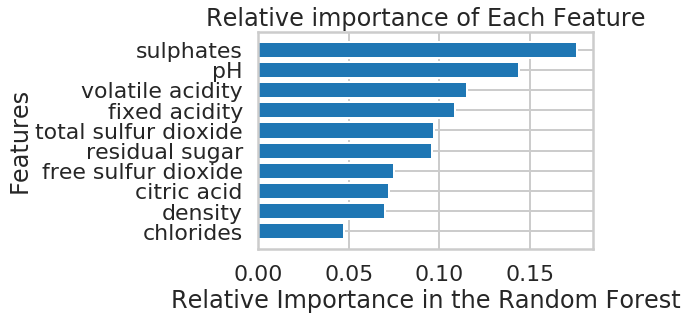

In [16]:
importance_list = clfForest.feature_importances_
name_list = df.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

# 3. More Ensemble Methods

Ensemble methods generalize this idea of putting many weak classifiers together (in a clever way) to build very accurate predictors. We saw this before with Random Forests and Bagging in the previous section. In this section we'll concentrate on a few particular Ensemble Methods

## AdaBoost Classifier
AdaBoost is short for Adaptive Boosting, the idea is quite simple. First you have some base classifier, like a Decision tree for example. 

First you assign to each of your n data points a weight of $w_i = 1/n$, then you do:

1. fit that classifier (e.g. tree) on all your data, weighted by $w_i$
2. test to see how well your classifier predicts your data
3. data points that are miss-classified get a slightly higher weight, but update all the weights to $w_{i, new} = w_{i} \exp({\alpha_{t, x_i, y_i}})$

In step 1, the way this weighting is done is by considering a weighted loss. For the details of this check out the Wikipedia article on [AdaBoost](https://en.wikipedia.org/wiki/AdaBoost#Example_algorithm_.28Discrete_AdaBoost.29). The only detail that is important to us now is that ${\alpha_{t, x_i, y_i}}$ is some number that is large when $y_i$ is correctly classified and small otherwise.

What this means is that every successive classifier (tree) puts more emphasis on classifying data points that the previous classifier missed. In this way each classifier can concentrate on a subset of the data. See the [help page](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) for more tuning parameters.

In [17]:
from sklearn.ensemble import AdaBoostClassifier

clfAda = AdaBoostClassifier()

parameters = {"n_estimators": range(10, 60)}
clfAda, Xtrain, ytrain, Xtest, ytest = do_classify(clfAda, parameters, 
                                                       df, Xnames, 'target', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


BEST {'n_estimators': 54} 0.39291655117467933 {'rank_test_score': array([ 3, 14, 17, 19,  8, 23, 31, 36, 28, 37, 40,  2, 27, 33, 30, 21, 22,
       12,  5, 35, 39, 50, 34, 46, 49, 26, 47, 38, 41, 10, 24, 24, 29, 45,
       43, 48, 44, 42, 32, 15, 20, 11,  7, 18,  1,  9,  6,  4, 16, 13],
      dtype=int32), 'split4_test_score': array([0.44444444, 0.43243243, 0.44444444, 0.43243243, 0.46153846,
       0.42105263, 0.46153846, 0.41860465, 0.47619048, 0.47619048,
       0.47619048, 0.6122449 , 0.57142857, 0.54901961, 0.54901961,
       0.54901961, 0.54901961, 0.54901961, 0.54901961, 0.42553191,
       0.45833333, 0.42553191, 0.45833333, 0.43478261, 0.42553191,
       0.45833333, 0.42553191, 0.39130435, 0.42553191, 0.42553191,
       0.42553191, 0.42553191, 0.39130435, 0.38297872, 0.4       ,
       0.36363636, 0.39130435, 0.4       , 0.37209302, 0.40909091,
       0.37209302, 0.4       , 0.37209302, 0.36363636, 0.37209302,
       0.37209302, 0.37209302, 0.38095238, 0.38095238, 0.37209302]),

## Gradient Boost Classifier

This classifier is also an ensemble method with trees as its base classifier, like AdaBoost it creates a sequence of classifiers that 'correct each other' sequentially. 

If you want to read more about this, and other Ensemble methods, check these places out:

- An Introduction to Statistical Learning by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani (see header)
- [Elements of Statistical Learning](http://statweb.stanford.edu/~tibs/ElemStatLearn/) by Trevor Hastie, Robert Tibshirani, Jerome Friedman
- [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting)
- [Boosting](https://en.wikipedia.org/wiki/Boosting_(machine_learning))
- [Ensemble Learning](https://en.wikipedia.org/wiki/Ensemble_learning)


In [18]:
from sklearn.ensemble import GradientBoostingClassifier

clfGB = GradientBoostingClassifier()

parameters = {"n_estimators": range(30, 60), "max_depth": [1, 2, 3, 4, 5]}
clfGB, Xtrain, ytrain, Xtest, ytest = do_classify(clfGB, parameters, 
                                                       df, Xnames, 'target', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask
BEST {'n_estimators': 43, 'max_depth': 4} 0.46474940075565724 {'std_train_score': array([0.06968113, 0.06968113, 0.06662752, 0.07951741, 0.07951741,
       0.05622815, 0.06213056, 0.06213056, 0.05990254, 0.05740524,
       0.05174653, 0.06295668, 0.05434386, 0.05653414, 0.06090656,
       0.06090656, 0.06807153, 0.05652052, 0.06807153, 0.06683559,
       0.05532773, 0.04597008, 0.04677007, 0.04317294, 0.04950789,
       0.0423969 , 0.05070684, 0.05173871, 0.0491415 , 0.04152423,
       0.03800194, 0.03986183, 0.04039509, 0.0396703 , 0.03968334,
       0.0354746 , 0.032639  , 0.02724789, 0.02851398, 0.03153475,
       0.03027252, 0.03937371, 0.03299189, 0.0389323 , 0.04347902,
       0.04009443, 0.04252451, 0.04681775, 0.04681775, 0.04884314,
       0.04759733, 0.04437881, 0.04138034, 0.04582599, 0.04093171,
       0.04351338, 0.04344212, 0.04695713, 0.04695713, 0.04540532,
       0.01690601, 0.02155899, 0.02919237, 0.02788039, 0.02360657,
       0.02397857, 0.02299439, 0.028

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Visualizing Classifiers Using Decision Surfaces
Using this function and the results from the "importance" analysis above, **subset** the data matrix to include just the **two features of highest importance**. Then **plot** the decision surfaces of a <a href='http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier'>decision tree classifier</a>,  and a random forest classifier with **number of trees set to 15**, and a <a href='http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC'> support vector machine</a> **with `C` set to 100, and `gamma` set to 1.0**. 

In [0]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.linear_model
import sklearn.svm

def plot_decision_surface(clf, X_train, Y_train):
    plot_step=0.1
    
    if X_train.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = X_train[:, 0].min() - plot_step, X_train[:, 0].max() + plot_step
    y_min, y_max = X_train[:, 1].min() - plot_step, X_train[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf.fit(X_train,Y_train)
    if hasattr(clf, 'predict_proba'):
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Reds)
    plt.scatter(X_train[:,0],X_train[:,1],c=Y_train,cmap=plt.cm.Paired)
    plt.show()
    
# your code here
imp_cols = clfForest.feature_importances_.argsort()[::-1][0:2]

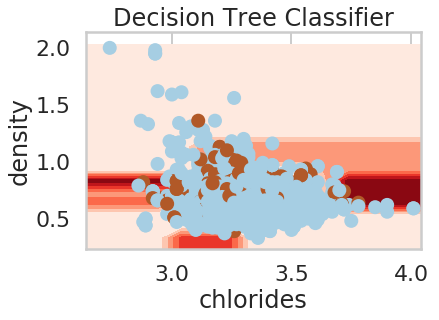

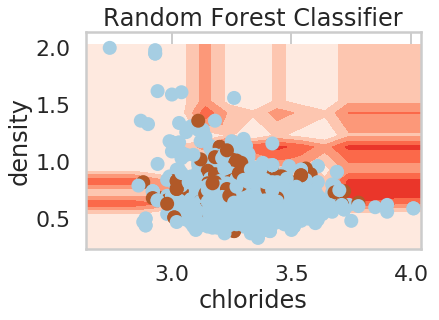

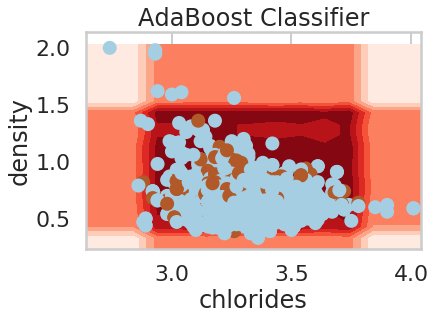

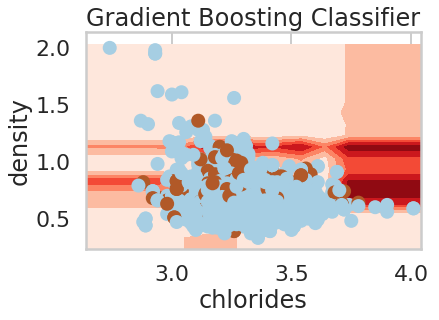

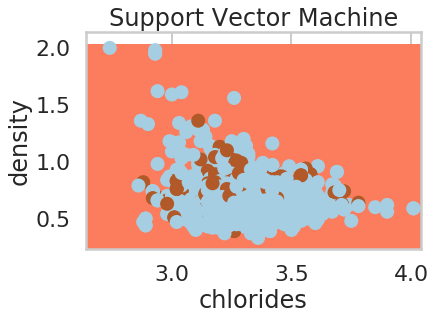

In [20]:
X_imp = df[['pH', 'sulphates']].values
# Y = df.target.values

classifiers = [clfTree2,
               clfForest,
               clfAda,
               clfGB,
               sklearn.svm.SVC(C=100.0, gamma=1.0)]

titleClassifer = ['Decision Tree Classifier', 'Random Forest Classifier', 
                  'AdaBoost Classifier', 'Gradient Boosting Classifier', 'Support Vector Machine']
for c in xrange(5):
    plt.title(titleClassifer[c])
    plt.xlabel(name_list[0])
    plt.ylabel(name_list[1])
    plot_decision_surface(classifiers[c], X_imp, df.target.values)

In [21]:
df.target

0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       1
8       1
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      1
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
       ..
1569    0
1570    0
1571    0
1572    0
1573    0
1574    0
1575    0
1576    0
1577    0
1578    0
1579    0
1580    0
1581    0
1582    0
1583    0
1584    1
1585    0
1586    0
1587    0
1588    0
1589    0
1590    0
1591    0
1592    0
1593    0
1594    0
1595    0
1596    0
1597    0
1598    0
Name: target, Length: 1599, dtype: int64